In [26]:
# Import
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import keras
from tensorflow import keras
from keras import layers
from keras.models import Sequential, load_model
from keras.layers import Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix
import warnings

warnings.filterwarnings('ignore')

In [2]:
# We can customize the batch size, image height, and image width
batch_size  = 32
img_height  = 224
img_width   = 224

# Constant value
CHECKPOINTS = "checkpoints"
LATEST_MODEL_NAME = "latest_model.keras"

In [24]:
# Save the current model
def save_model(model, model_name):
    try:
        model.save(CHECKPOINTS + os.sep + model_name + LATEST_MODEL_NAME)
    except Exception as e:
        print(e)
        raise e
    
    print("Model has succesfully saved")
    
def load_model_function(model_name):
    try:
        model_file = CHECKPOINTS + os.sep + model_name + LATEST_MODEL_NAME
        model = load_model(model_file)

        return model
    except Exception as e:
        raise e

In [22]:
model = load_model_function()

I0000 00:00:1726497067.630775    3811 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726497067.911115    3811 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726497067.913450    3811 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726497067.918360    3811 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [4]:
(train_ds, val_ds) = tf.keras.preprocessing.image_dataset_from_directory(
    "datasets/Gastrovision",
    validation_split=0.2,
    subset="both",
    seed=69420,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2426 files belonging to 3 classes.
Using 1941 files for training.
Using 485 files for validation.


I0000 00:00:1726854554.131948    2554 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726854554.291517    2554 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726854554.293767    2554 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726854554.297058    2554 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

### Visualization

2024-09-16 01:26:11.991787: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


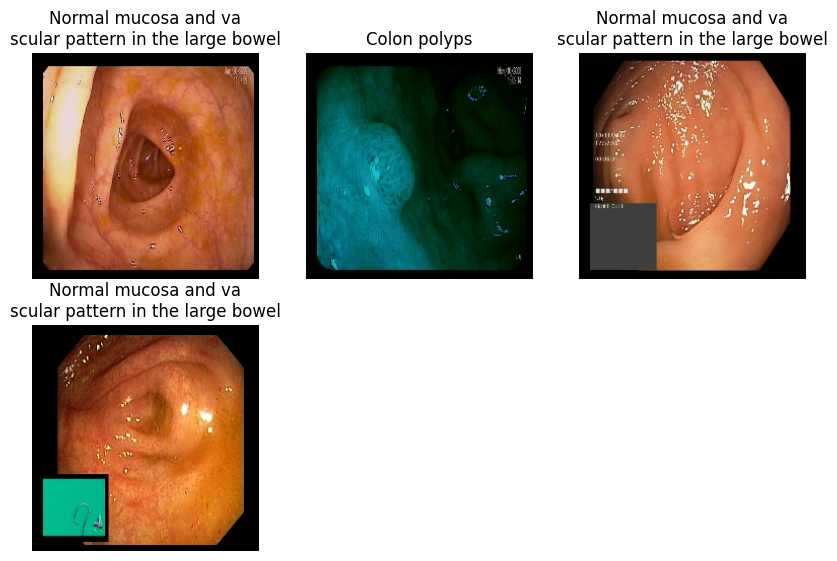

In [4]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(4):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]] if len(class_names[labels[i]]) < 20 else (class_names[labels[i]][:20]) + "\n" + (class_names[labels[i]][20:]))
        plt.axis("off")

In [5]:
augmentation = {
    "training": Sequential([
        layers.RandomRotation(factor=0.15),
        layers.RandomFlip(mode="horizontal")
    ]),

    "validation": Sequential([
    ]),
}

In [6]:
# Resnet
resnet_base = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

# Densenet
densenet_base = tf.keras.applications.DenseNet169(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [17]:
resnet_base.trainable=True
densenet_base.trainable=True

for layer in resnet_base.layers[:-4]:
    layer.trainable=False
    
for layer in densenet_base.layers[:-4]:
    layer.trainable=False

In [18]:
inputs = keras.Input(shape=(224, 224, 3))
x = augmentation["training"](inputs)
x = keras.applications.densenet.preprocess_input(x)
x = densenet_base(x)
x = Flatten()(x)
x = Dense(256)(x)
x = Dropout(0.5)(x)
outputs = Dense(units=3, activation='softmax')(x)
model= keras.Model(inputs=inputs, outputs=outputs)

In [19]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_4 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ add_2 (Add)                     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_5 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet169 (Functional)        │ (None, 7, 7, 1664)     │    12,642,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 81536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │    20,873,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,517,123 (127.86 MB)

 Trainable params: 20,914,435 (79.78 MB)

 Non-trainable params: 12,602,688 (48.08 MB)

In [20]:
model.compile(
    optimizer="adam",
    loss=tf.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [21]:
def get_early_stopping():
    return tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

early_stopping = get_early_stopping()

callbacks = [early_stopping]

In [22]:
history = model.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=30, callbacks=callbacks)

Epoch 1/30


2024-09-21 00:55:06.556166: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1726854906.844332    3746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854906.880869    3746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854906.885462    3746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854906.891040    3746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854906.896572    3746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854906.923292    3746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854906.938953    3746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854906.954881    3746 gpu_t

 1/61 ━━━━━━━━━━━━━━━━━━━━ 18:51 19s/step - accuracy: 0.2188 - loss: 2.7756

W0000 00:00:1726854911.787930    3746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854911.793961    3746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854911.800247    3746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854911.801433    3746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854911.804612    3746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854911.812511    3746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854911.813678    3746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854911.814840    3746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854911.816070    3746 gp

60/61 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - accuracy: 0.5774 - loss: 56.2959

W0000 00:00:1726854926.846995    3744 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854926.849854    3744 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854926.852699    3744 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854926.855907    3744 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854926.859141    3744 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854926.863972    3744 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854926.870152    3744 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854926.875567    3744 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854926.881758    3744 gp

61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.5785 - loss: 56.0927

W0000 00:00:1726854930.693854    3746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854930.710535    3746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854930.711631    3746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854930.712864    3746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854930.713999    3746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854930.715143    3746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854930.716367    3746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854930.717699    3746 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854930.719014    3746 gp

61/61 ━━━━━━━━━━━━━━━━━━━━ 48s 478ms/step - accuracy: 0.5796 - loss: 55.8961 - val_accuracy: 0.7938 - val_loss: 21.1047
Epoch 2/30


W0000 00:00:1726854940.314853    3747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854940.316013    3747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854940.317135    3747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854940.318300    3747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854940.319487    3747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854940.320642    3747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854940.321914    3747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854940.323140    3747 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1726854940.324387    3747 gp

61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 317ms/step - accuracy: 0.7826 - loss: 17.9279 - val_accuracy: 0.7505 - val_loss: 18.1892
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 316ms/step - accuracy: 0.7767 - loss: 13.7441 - val_accuracy: 0.7691 - val_loss: 15.9477
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 317ms/step - accuracy: 0.7811 - loss: 12.9654 - val_accuracy: 0.8082 - val_loss: 9.7616
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 318ms/step - accuracy: 0.8004 - loss: 10.6087 - val_accuracy: 0.8186 - val_loss: 8.4277
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 318ms/step - accuracy: 0.8050 - loss: 9.6940 - val_accuracy: 0.8041 - val_loss: 8.5676
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 318ms/step - accuracy: 0.8333 - loss: 6.3898 - val_accuracy: 0.7567 - val_loss: 12.0069
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 319ms/step - accuracy: 0.8251 - loss: 7.5072 - val_accuracy: 0.8206 - val_loss: 7.7625
Epoch 9/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 319ms/step - accuracy: 0.8297 - loss: 4.5863 - val_accuracy

In [23]:
predictions = np.array([])
labels =  np.array([])
for x, y in val_ds:
  Y_pred=model.predict(x)
  y_prediction = np.argmax(Y_pred, axis=1)
  predictions = np.concatenate([predictions, y_prediction])
  labels = np.concatenate([labels, y.numpy()])
     

print('Confusion Matrix')
print(confusion_matrix(y_true=labels, y_pred=predictions))

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Confusion Matrix
[[114   2  46]
 [ 11  12   3]
 [ 16   1 280]]


2024-09-21 01:05:27.224080: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [25]:
save_model(model=model, model_name="densenet_169_")

Model has succesfully saved
